# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn, dummy

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset for Well 1 and labels 0 (Normal conditions) and 5 (RAPID PRODUCTIVITY LOSS) ordered by date.

In [5]:
dset.get_df().groupby('label').count()

,ts,path,nlines
label,,,
0,597,597,597
1,5,129,129
2,22,38,38
3,32,106,106
4,344,344,344
5,12,451,451
6,6,221,221
7,4,14,14
8,0,81,81


,ts,label,path,nlines
178,2014-03-18 02:31:41,5,..\dataset\5\WELL-00017_20140318023141.csv,41178
264,2014-03-17 15:17:43,5,..\dataset\5\WELL-00017_20140317151743.csv,35754
277,2014-03-18 16:02:20,5,..\dataset\5\WELL-00017_20140318160220.csv,35861
494,2018-05-17 22:23:22,5,..\dataset\5\WELL-00016_20180517222322.csv,11974
509,2017-06-20 16:03:49,5,..\dataset\5\WELL-00015_20170620160349.csv,11182
594,2018-04-26 14:51:08,5,..\dataset\5\WELL-00016_20180426145108.csv,3193
694,2018-04-05 02:03:45,5,..\dataset\5\WELL-00016_20180405020345.csv,3311
709,2018-04-26 14:20:05,5,..\dataset\5\WELL-00016_20180426142005.csv,1440
841,2014-03-19 14:14:50,5,..\dataset\5\WELL-00017_20140319141450.csv,48905
1088,2017-10-13 14:00:47,5,..\dataset\5\WELL-00015_20171013140047.csv,7754


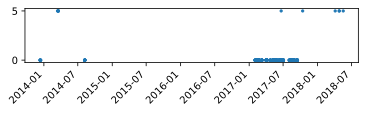

In [6]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[0, 5, 105]

data_df = dset.get_df()
data_df = data_df.sample(frac=1, random_state=200560).reset_index(drop=True)
data_df = data_df[data_df.label.isin([0, 5])]
# data_df = data_df.sort_values('ts').reset_index(drop=True)
plt.figure(figsize=(6, 1))
y = data_df.sort_values(['label', 'ts']).label
x = data_df.sort_values(['label', 'ts']).ts
plt.scatter(x=x, y=y.apply(str), s=5)
plt.xticks(rotation = 45, ha="right")
display(data_df[(data_df.label==5) & (data_df.ts.notnull())])
plt.show()

In [9]:
display(data_df[(data_df.label==5)])

,ts,label,path,nlines
1,NaT,5,..\dataset\5\SIMULATED_00322.csv,29299
6,NaT,5,..\dataset\5\SIMULATED_00386.csv,29299
7,NaT,5,..\dataset\5\SIMULATED_00060.csv,29299
14,NaT,5,..\dataset\5\SIMULATED_00132.csv,29299
16,NaT,5,..\dataset\5\SIMULATED_00311.csv,29299
...,...,...,...,...
1953,NaT,5,..\dataset\5\SIMULATED_00430.csv,29299
1955,NaT,5,..\dataset\5\SIMULATED_00028.csv,29299
1960,NaT,5,..\dataset\5\SIMULATED_00082.csv,29299
1967,NaT,5,..\dataset\5\SIMULATED_00177.csv,29299


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [10]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                dss[i_col][self.target] = dss[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [11]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2018-04-14 12:15:00 {'P-PDG': 0.48801191700633456, 'P-TPT': 0.254082252896457, 'T-TPT': 2.276408145957185, 'P-MON-CKP': 0.1356170606638037, 'T-JUS-CKP': 1.751715107356322, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-04-14 12:16:00 {'P-PDG': 0.49298067002683743, 'P-TPT': 0.2590974244257955, 'T-TPT': 2.275716305887111, 'P-MON-CKP': 0.142630798315507, 'T-JUS-CKP': 1.7554665525488442, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-04-14 12:17:00 {'P-PDG': 0.49737281011108014, 'P-TPT': 0.2635034830627749, 'T-TPT': 2.274498832979524, 'P-MON-CKP': 0.14949585925089973, 'T-JUS-CKP': 1.7593038298185166, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2018-04-14 12:18:00 {'P-PDG': 0.5009096962376502, 'P-TPT': 0.2670294270985173, 'T-TPT': 2.272745671992652, 'P-MON-CKP': 0.15582441622156298, 'T-JUS-CKP': 1.7630670423119306, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


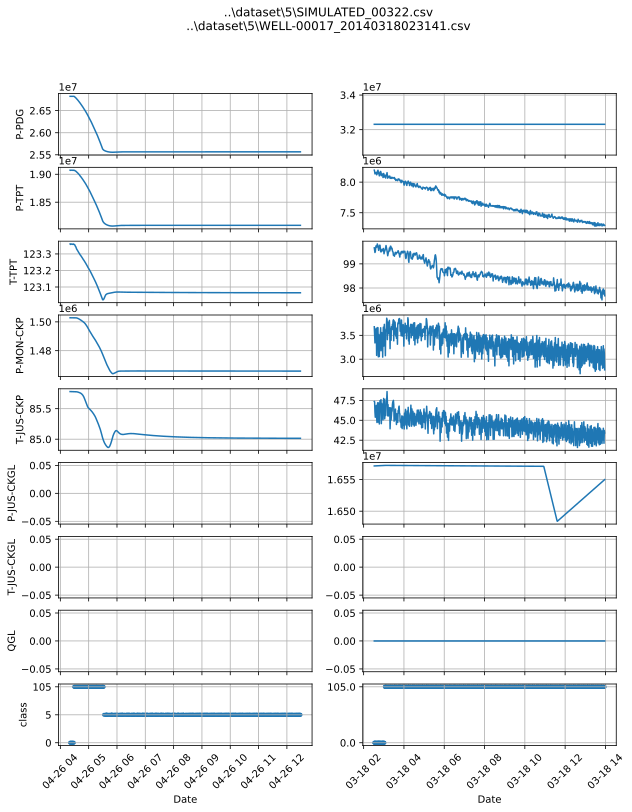

In [12]:
gen.plot([1, 178])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [33]:
def plot_acc0(i_s, i_sD, accuracies, accuraciesD, first, second):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(i_s, accuracies, label=first)
    plt.plot(i_sD, accuraciesD, label=second)
    plt.legend(loc="lower right")
    plt.title('Accuracies')
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    
    plt.show()
    return

In [34]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    dummymodel = dummy.NoChangeClassifier()
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    dummyreport = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    y_dummies = []
    accuracies = []
    dummyaccuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            y_dummy = dummymodel.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                y_dummy = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            dummyreport = dummyreport.update(y, y_dummy)

            if not EvalB:
                model.learn_one(xd, y)
                dummymodel.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            y_dummies.append(y_dummy)
            accuracies.append(report.get())
            dummyaccuracies.append(dummyreport.get())
            ifiles.append(ifile)
            i_s.append(i)

    print('\n', report)
    print('\n NoChangeClassifier', dummyreport)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, y_dummies, accuracies, dummyaccuracies, report, dummyreport, ifiles,\
                model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, y_dummies, accuracies, dummyaccuracies, report, dummyreport, ifiles, model

In [36]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
Basemodel = imblearn.RandomOverSampler(tree.HoeffdingTreeClassifier(delta=1.E-4),
            desired_dist={0: 0.5, 5: 0.4, 105: 0.1}, seed=200560)
# model = imblearn.RandomOverSampler(multiclass.OneVsOneClassifier(linear_model.ALMAClassifier(alpha=0.85, B=1./0.85)),
#                                   desired_dist={0: 0.4, 102: 0.2, 2: 0.4}, seed=200560)
model = deepcopy(Basemodel)


flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 30

i_s, ys, y_preds, y_dummies, accuracies, dummyaccuracies, report, dummyreport, ifiles, model, df =\
                 fit_model(data_df, flist, 'class', window_size, model, dfB=True, EvalB=False)


files learned  1048 / 1048
 BalancedAccuracy: 94.55%

 NoChangeClassifier BalancedAccuracy: 99.38%

            Precision   Recall   F1       Support  
                                                  
     0.0      93.83%   99.22%   96.45%    149507  
     5.0      98.84%   92.16%   95.38%    176072  
   105.0      83.48%   92.28%   87.66%     31395  
                                                  
   Macro      92.05%   94.55%   93.16%            
   Micro      95.13%   95.13%   95.13%            
Weighted      95.39%   95.13%   95.15%            

                 95.13% accuracy                  
CPU times: total: 8min 24s
Wall time: 9min 13s


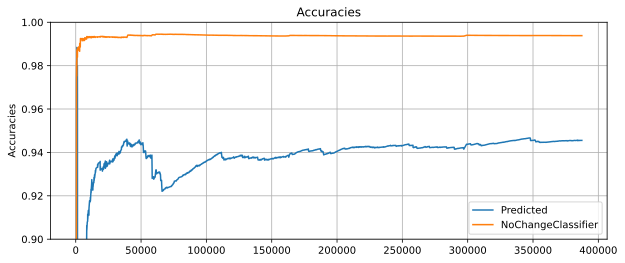

In [37]:
plot_acc0(i_s, i_s, accuracies, dummyaccuracies, 'Predicted', 'NoChangeClassifier')

In [49]:
model.classifier.draw(max_depth=4).render('model', format='jpg', view=False)
pd.DataFrame.from_dict(model.classifier.summary, 'index').transpose()


(dot.exe:3272): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


,n_nodes,n_branches,n_leaves,n_active_leaves,n_inactive_leaves,height,total_observed_weight
0,205.0,102.0,103.0,103.0,0.0,28.0,447320.0


In [50]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    149507
         5.0       0.99      0.92      0.95    176072
       105.0       0.83      0.92      0.88     31395

    accuracy                           0.95    356974
   macro avg       0.92      0.95      0.93    356974
weighted avg       0.95      0.95      0.95    356974



In [51]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 15207
P-MON-CKP_rSEM 15207
P-MON-CKP_rMax 15207
P-MON-CKP_rMin 15207
T-JUS-CKP_rmean 22198
T-JUS-CKP_rSEM 22198
T-JUS-CKP_rMax 22198
T-JUS-CKP_rMin 22198
class 0
P-JUS-CKGL_rmean 239573
P-JUS-CKGL_rSEM 239573
P-JUS-CKGL_rMax 239573
P-JUS-CKGL_rMin 239573
QGL_rmean 239391
QGL_rSEM 239391
QGL_rMax 239391
QGL_rMin 239391
mean accuracy Random Forest:  0.9998095099362979
            var    varImp
4   P-TPT_rmean  0.163776
1    P-PDG_rSEM  0.154995
2    P-PDG_rMax  0.104410
6    P-TPT_rMax  0.100102
11   T-TPT_rMin  0.093243
3    P-PDG_rMin  0.091332
8   T-TPT_rmean  0.087067
7    P-TPT_rMin  0.067856
10   T-TPT_rMax  0.054619
5    P-TPT_rSEM  0.043399
9    T-TPT_rSEM  0.024197
0   P-PDG_rmean  0.015003
CPU times: total: 8.67 s
Wall time: 9.07 s


,var,varImp
0,P-TPT,0.375133
1,P-PDG,0.365740
2,T-TPT,0.259126


In [52]:
# Random Forest on validation set
print(classification_report(df['class'], forest.predict((df[f_list]))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    149507
         5.0       1.00      1.00      1.00    176072
       105.0       1.00      1.00      1.00     31395

    accuracy                           1.00    356974
   macro avg       1.00      1.00      1.00    356974
weighted avg       1.00      1.00      1.00    356974



[]

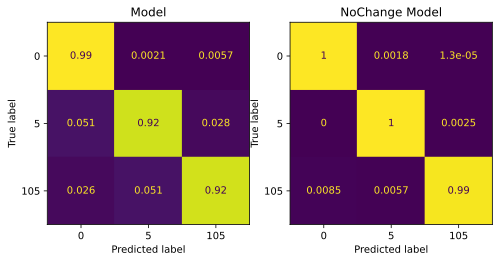

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

_ = ConfusionMatrixDisplay(confusion_matrix(ys, y_preds, labels=categories, normalize='true'), 
                       display_labels=categories).plot(ax=ax[0], colorbar=False)
_ = ConfusionMatrixDisplay(confusion_matrix(ys, y_dummies, labels=categories, normalize='true'), 
                       display_labels=categories).plot(ax=ax[1], colorbar=False)
ax[0].set_title('Model')
ax[1].set_title('NoChange Model')
plt.plot()

## Drift test

In [54]:
def plot_acc(i_s, i_sD, accuracies, accuraciesD, dr, first, second):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(i_s, accuracies, label=first)
    plt.plot(i_sD, accuraciesD, label=second)
    plt.legend(loc="lower right")
    plt.title('Accuracies')
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
#     plt.grid()
    
    res = dr.to_df()
    res0 = res[res.change == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='green', alpha=0.25)
    res0 = res[res.new_model == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='red')
    plt.show()
    return

In [55]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'new_model': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change, new_model):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['new_model'].append(new_model)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)
    def get_changes(self):
        return sum(self.d['change'])

In [56]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, drd0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
        n_model = 0
#     drd = deepcopy(drd0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = deepcopy(drd0)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if hasattr(drd, "warning_detected") and drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                if n_model > 5000: # New model if at least 5000 instances has been learnt
                    model = deepcopy(model0) #model reinitialization
                    j = 0
                    n_model = 0
                    print('*** model reinitializated ***')
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, True)
                else:
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
                    
            n += 1

            if not EvalB:
                model.learn_one(xd, y)
                n_model += 1

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)
            i_s.append(i)
            
    print('\n', report)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, accuracies, report, ifiles, model

### ADWIN

In [57]:
%%time

modelD = deepcopy(Basemodel)

#delta=0.002, clock=32, max_buckets=5, min_window_length=5, grace_period=10
drd = drift.ADWIN(delta=0.002, clock=32, min_window_length=5, grace_period=10)
dr_ADWIN = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_ADWIN, drd, dfB=False, EvalB=False)    

files learned  14 / 1048
Change detected at index 5151 287, ifile 13, label 5 5.0 SIMULATED_00425
files learned  16 / 1048
Change detected at index 5907 255, ifile 15, label 5 5.0 SIMULATED_00356
*** model reinitializated ***
files learned  23 / 1048
Change detected at index 8600 287, ifile 22, label 5 5.0 SIMULATED_00032
files learned  25 / 1048
Change detected at index 9390 287, ifile 24, label 5 5.0 SIMULATED_00208
files learned  31 / 1048
Change detected at index 11311 159, ifile 30, label 5 5.0 SIMULATED_00184
files learned  32 / 1048
Change detected at index 11896 255, ifile 31, label 5 5.0 SIMULATED_00222
*** model reinitializated ***
files learned  38 / 1048
Change detected at index 14106 223, ifile 37, label 5 5.0 SIMULATED_00093

Change detected at index 14234 351, ifile 37, label 5 5.0 SIMULATED_00093
files learned  39 / 1048
Change detected at index 14531 159, ifile 38, label 5 5.0 SIMULATED_00183
files learned  41 / 1048
Change detected at index 15142 159, ifile 40, label 

files learned  290 / 1048
Change detected at index 107135 223, ifile 289, label 5 5.0 SIMULATED_00023
files learned  292 / 1048
Change detected at index 108010 319, ifile 291, label 5 5.0 SIMULATED_00140
files learned  295 / 1048
Change detected at index 109127 159, ifile 294, label 5 5.0 SIMULATED_00376
files learned  298 / 1048
Change detected at index 110310 255, ifile 297, label 5 5.0 SIMULATED_00025
files learned  302 / 1048
Change detected at index 111791 351, ifile 301, label 5 5.0 SIMULATED_00003
*** model reinitializated ***
files learned  306 / 1048
Change detected at index 113333 319, ifile 305, label 5 5.0 SIMULATED_00004
files learned  307 / 1048
Change detected at index 113727 223, ifile 306, label 0 0.0 WELL-00002_20170309120156
files learned  311 / 1048
Change detected at index 115399 127, ifile 310, label 5 5.0 SIMULATED_00235
files learned  314 / 1048
Change detected at index 116743 383, ifile 313, label 5 5.0 SIMULATED_00428
files learned  320 / 1048
Change detected 

files learned  533 / 1048
Change detected at index 195752 223, ifile 532, label 5 5.0 SIMULATED_00159
files learned  535 / 1048
Change detected at index 196442 127, ifile 534, label 0 0.0 WELL-00006_20170210010135

Change detected at index 196570 255, ifile 534, label 0 0.0 WELL-00006_20170210010135
files learned  537 / 1048
Change detected at index 197137 223, ifile 536, label 0 0.0 WELL-00003_20170914110000
*** model reinitializated ***
files learned  539 / 1048
Change detected at index 197829 127, ifile 538, label 5 5.0 SIMULATED_00317
files learned  540 / 1048
Change detected at index 198319 127, ifile 539, label 5 5.0 SIMULATED_00401
files learned  541 / 1048
Change detected at index 198808 127, ifile 540, label 5 5.0 SIMULATED_00236
files learned  542 / 1048
Change detected at index 199297 127, ifile 541, label 5 5.0 SIMULATED_00225
files learned  543 / 1048
Change detected at index 199787 127, ifile 542, label 5 5.0 SIMULATED_00275
files learned  545 / 1048
Change detected at in

files learned  750 / 1048
Change detected at index 277467 255, ifile 749, label 5 5.0 SIMULATED_00226
files learned  758 / 1048
Change detected at index 280656 287, ifile 757, label 5 5.0 SIMULATED_00237
*** model reinitializated ***
files learned  765 / 1048
Change detected at index 282839 191, ifile 764, label 5 5.0 SIMULATED_00250
files learned  768 / 1048
Change detected at index 283892 159, ifile 767, label 5 5.0 SIMULATED_00015
files learned  771 / 1048
Change detected at index 285328 127, ifile 770, label 5 5.0 SIMULATED_00089
files learned  781 / 1048
Change detected at index 288889 127, ifile 780, label 0 0.0 WELL-00002_20170806130000
*** model reinitializated ***
files learned  784 / 1048
Change detected at index 289846 191, ifile 783, label 5 5.0 SIMULATED_00094
files learned  785 / 1048
Change detected at index 290271 127, ifile 784, label 5 5.0 SIMULATED_00069
files learned  786 / 1048
Change detected at index 290760 127, ifile 785, label 5 5.0 SIMULATED_00215
files learne

files learned  980 / 1048
Change detected at index 363698 159, ifile 979, label 5 5.0 SIMULATED_00251
files learned  985 / 1048
Change detected at index 365383 287, ifile 984, label 5 5.0 SIMULATED_00242
files learned  991 / 1048
Change detected at index 367609 287, ifile 990, label 5 5.0 SIMULATED_00378
*** model reinitializated ***
files learned  996 / 1048
Change detected at index 369051 223, ifile 995, label 5 5.0 SIMULATED_00133
files learned  1000 / 1048
Change detected at index 370692 223, ifile 999, label 0 0.0 WELL-00008_20170614030135
files learned  1002 / 1048
Change detected at index 371258 191, ifile 1001, label 5 5.0 SIMULATED_00276
files learned  1003 / 1048
Change detected at index 371876 319, ifile 1002, label 5 5.0 SIMULATED_00039
files learned  1006 / 1048
Change detected at index 372680 159, ifile 1005, label 5 5.0 SIMULATED_00419
files learned  1018 / 1048
Change detected at index 376770 255, ifile 1017, label 5 5.0 SIMULATED_00091
*** model reinitializated ***
fil

In [58]:
print('Number of drift points detected: {}'.format(dr_ADWIN.get_changes()))

Number of drift points detected: 330


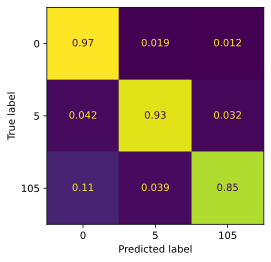

In [59]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

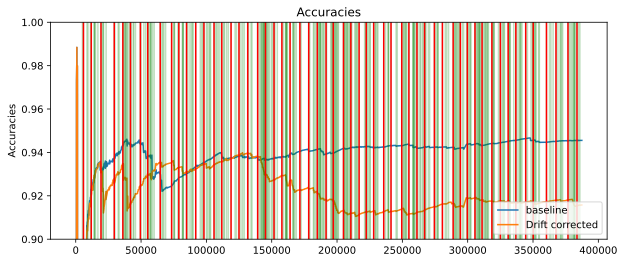

In [60]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_ADWIN, 'baseline', 'Drift corrected',
        drift.ADWIN(delta=0.002, clock=32, min_window_length=5, grace_period=10))

### DDM

In [61]:
modelD = deepcopy(Basemodel)

drd = drift.DDM(warm_start=100, warning_threshold=2.0, drift_threshold=3.0) #warm_start=30, warning_threshold=2.0, drift_threshold=3.0
dr_DDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_DDM, drd, dfB=False, EvalB=False)    

files learned  10 / 1048
Change detected at index 3609 126, ifile 9, label 5 5.0 SIMULATED_00311
files learned  11 / 1048
Warning detected at index 4089 117, ifile 10, label 0 0.0 WELL-00002_20170810070000

Change detected at index 4091 119, ifile 10, label 0 0.0 WELL-00002_20170810070000
files learned  23 / 1048
Warning detected at index 8440 127, ifile 22, label 5 5.0 SIMULATED_00032

Change detected at index 8441 128, ifile 22, label 5 5.0 SIMULATED_00032
*** model reinitializated ***
files learned  33 / 1048
Warning detected at index 12298 168, ifile 32, label 5 5.0 SIMULATED_00211

Change detected at index 12299 169, ifile 32, label 5 5.0 SIMULATED_00211

Warning detected at index 12444 314, ifile 32, label 5 5.0 SIMULATED_00211
files learned  38 / 1048
Warning detected at index 14040 157, ifile 37, label 5 5.0 SIMULATED_00093

Change detected at index 14042 159, ifile 37, label 5 5.0 SIMULATED_00093
*** model reinitializated ***
files learned  42 / 1048
Warning detected at index 

files learned  322 / 1048
Warning detected at index 119663 151, ifile 321, label 0 0.0 WELL-00002_20170626130032

Change detected at index 119666 154, ifile 321, label 0 0.0 WELL-00002_20170626130032
files learned  327 / 1048
Warning detected at index 120875 103, ifile 326, label 5 5.0 SIMULATED_00008

Change detected at index 120877 105, ifile 326, label 5 5.0 SIMULATED_00008
files learned  329 / 1048
Warning detected at index 121856 105, ifile 328, label 5 5.0 SIMULATED_00216

Change detected at index 121862 111, ifile 328, label 5 5.0 SIMULATED_00216
*** model reinitializated ***
files learned  331 / 1048
Warning detected at index 122535 114, ifile 330, label 0 0.0 WELL-00006_20170819100000

Change detected at index 122553 132, ifile 330, label 0 0.0 WELL-00006_20170819100000
files learned  341 / 1048
Change detected at index 125921 122, ifile 340, label 5 105.0 SIMULATED_00171
files learned  345 / 1048
Warning detected at index 127666 106, ifile 344, label 5 5.0 SIMULATED_00030

Ch

files learned  653 / 1048
Change detected at index 241609 182, ifile 652, label 0 0.0 WELL-00006_20170819050000
files learned  664 / 1048
Warning detected at index 245004 207, ifile 663, label 5 5.0 SIMULATED_00014

Change detected at index 245016 219, ifile 663, label 5 5.0 SIMULATED_00014
*** model reinitializated ***
files learned  668 / 1048
Warning detected at index 246552 108, ifile 667, label 0 0.0 WELL-00001_20170521050000

Change detected at index 246553 109, ifile 667, label 0 0.0 WELL-00001_20170521050000
files learned  670 / 1048
Warning detected at index 247353 122, ifile 669, label 0 0.0 WELL-00002_20170622190316

Change detected at index 247360 129, ifile 669, label 0 0.0 WELL-00002_20170622190316
files learned  671 / 1048
Warning detected at index 247692 163, ifile 670, label 0 0.0 WELL-00002_20170618020105

Change detected at index 247700 171, ifile 670, label 0 0.0 WELL-00002_20170618020105
files learned  691 / 1048
Warning detected at index 254969 118, ifile 690, lab

In [62]:
print('Number of drift points detected: {}'.format(dr_DDM.get_changes()))

Number of drift points detected: 121


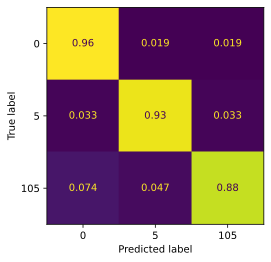

In [63]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

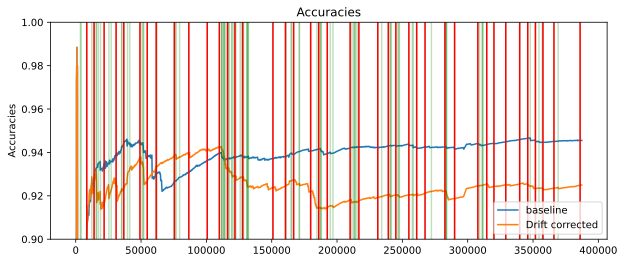

In [64]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_DDM, 'baseline', 'Drift corrected')

### EDDM

In [65]:
modelD = deepcopy(Basemodel)

drd = drift.EDDM(warm_start=30, alpha=0.95, beta=0.9) #warm_start=30, alpha=0.95, beta=0.9
dr_EDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_EDDM, drd, dfB=False, EvalB=False)    

files learned  4 / 1048
Warning detected at index 1349 43, ifile 3, label 5 5.0 SIMULATED_00060

Change detected at index 1374 68, ifile 3, label 5 5.0 SIMULATED_00060
files learned  16 / 1048
Change detected at index 5719 67, ifile 15, label 5 5.0 SIMULATED_00356
*** model reinitializated ***
files learned  23 / 1048
Change detected at index 8470 157, ifile 22, label 5 5.0 SIMULATED_00032
files learned  25 / 1048
Change detected at index 9193 90, ifile 24, label 5 5.0 SIMULATED_00208
files learned  33 / 1048
Change detected at index 12325 195, ifile 32, label 5 5.0 SIMULATED_00211
*** model reinitializated ***
files learned  52 / 1048
Change detected at index 18952 293, ifile 51, label 5 5.0 SIMULATED_00088
*** model reinitializated ***
files learned  59 / 1048
Change detected at index 21208 74, ifile 58, label 5 5.0 SIMULATED_00135
files learned  70 / 1048
Change detected at index 26018 71, ifile 69, label 5 5.0 SIMULATED_00167
*** model reinitializated ***
files learned  81 / 1048
C

files learned  420 / 1048
Warning detected at index 155000 65, ifile 419, label 5 5.0 SIMULATED_00144

Change detected at index 155016 81, ifile 419, label 5 5.0 SIMULATED_00144
*** model reinitializated ***
files learned  436 / 1048
Change detected at index 160535 163, ifile 435, label 5 5.0 SIMULATED_00029
*** model reinitializated ***
files learned  442 / 1048
Change detected at index 163221 296, ifile 441, label 5 105.0 WELL-00017_20140319141450

Change detected at index 163398 473, ifile 441, label 5 105.0 WELL-00017_20140319141450
files learned  468 / 1048
Change detected at index 172943 71, ifile 467, label 0 0.0 WELL-00008_20170817050135
*** model reinitializated ***
files learned  471 / 1048
Change detected at index 174057 221, ifile 470, label 0 0.0 WELL-00006_20170507180103
files learned  473 / 1048
Warning detected at index 174480 43, ifile 472, label 0 0.0 WELL-00006_20170506020103

Change detected at index 174505 68, ifile 472, label 0 0.0 WELL-00006_20170506020103
files 

files learned  784 / 1048
Change detected at index 289769 114, ifile 783, label 5 5.0 SIMULATED_00094

Change detected at index 289959 304, ifile 783, label 5 5.0 SIMULATED_00094

Warning detected at index 290092 437, ifile 783, label 5 5.0 SIMULATED_00094
files learned  785 / 1048
Warning detected at index 290183 39, ifile 784, label 5 105.0 SIMULATED_00069

Change detected at index 290189 45, ifile 784, label 5 105.0 SIMULATED_00069
files learned  788 / 1048
Warning detected at index 291298 55, ifile 787, label 5 105.0 SIMULATED_00037

Change detected at index 291335 92, ifile 787, label 5 5.0 SIMULATED_00037
*** model reinitializated ***
files learned  793 / 1048
Change detected at index 293020 80, ifile 792, label 5 5.0 SIMULATED_00313
files learned  798 / 1048
Change detected at index 295069 61, ifile 797, label 0 0.0 WELL-00008_20170612140047

Warning detected at index 295113 105, ifile 797, label 0 0.0 WELL-00008_20170612140047

Change detected at index 295216 208, ifile 797, la

In [66]:
print('Number of drift points detected: {}'.format(dr_EDDM.get_changes()))

Number of drift points detected: 170


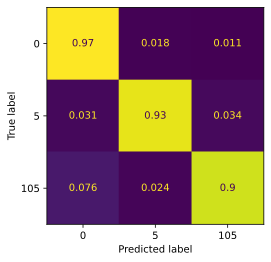

In [67]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

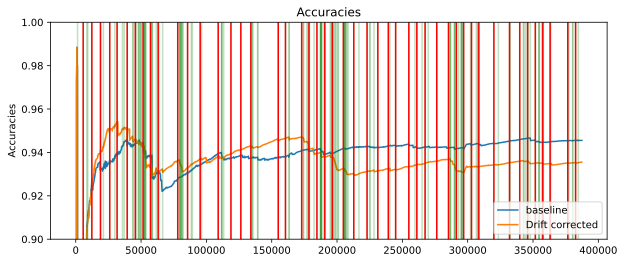

In [68]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_EDDM, 'baseline', 'Drift corrected')

### HDDM_A

In [69]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_A(drift_confidence=0.00005, warning_confidence=0.0001) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM_A = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                modelD, dr_HDDM_A, drd, dfB=False, EvalB=False)    

files learned  3 / 1048
Change detected at index 873 56, ifile 2, label 5 5.0 SIMULATED_00386
files learned  10 / 1048
Change detected at index 3614 131, ifile 9, label 5 5.0 SIMULATED_00311
files learned  11 / 1048
Change detected at index 4093 121, ifile 10, label 0 0.0 WELL-00002_20170810070000
files learned  14 / 1048
Change detected at index 4923 59, ifile 13, label 5 5.0 SIMULATED_00425
files learned  16 / 1048
Warning detected at index 5702 50, ifile 15, label 5 105.0 SIMULATED_00356
files learned  23 / 1048
Change detected at index 8445 132, ifile 22, label 5 5.0 SIMULATED_00032
*** model reinitializated ***
files learned  25 / 1048
Warning detected at index 9179 76, ifile 24, label 5 5.0 SIMULATED_00208
files learned  31 / 1048
Warning detected at index 11200 48, ifile 30, label 5 5.0 SIMULATED_00184

Change detected at index 11201 49, ifile 30, label 5 5.0 SIMULATED_00184
files learned  32 / 1048
Change detected at index 11705 64, ifile 31, label 5 5.0 SIMULATED_00222
files l

files learned  152 / 1048
Change detected at index 58171 238, ifile 151, label 5 105.0 WELL-00017_20140317151743
files learned  157 / 1048
Change detected at index 59795 65, ifile 156, label 5 5.0 SIMULATED_00038
files learned  158 / 1048
Change detected at index 60285 65, ifile 157, label 5 5.0 SIMULATED_00195
files learned  161 / 1048
Change detected at index 61660 173, ifile 160, label 0 0.0 WELL-00008_20170818160123
*** model reinitializated ***
files learned  163 / 1048
Warning detected at index 62195 114, ifile 162, label 5 5.0 SIMULATED_00050

Change detected at index 62196 115, ifile 162, label 5 5.0 SIMULATED_00050
files learned  177 / 1048
Change detected at index 66529 56, ifile 176, label 5 5.0 SIMULATED_00394
files learned  179 / 1048
Warning detected at index 67202 65, ifile 178, label 5 5.0 SIMULATED_00027

Change detected at index 67203 66, ifile 178, label 5 5.0 SIMULATED_00027
files learned  189 / 1048
Warning detected at index 70419 27, ifile 188, label 0 0.0 WELL-00

files learned  295 / 1048
Warning detected at index 109024 56, ifile 294, label 5 5.0 SIMULATED_00376

Change detected at index 109025 57, ifile 294, label 5 5.0 SIMULATED_00376
files learned  298 / 1048
Warning detected at index 110120 65, ifile 297, label 5 5.0 SIMULATED_00025

Change detected at index 110121 66, ifile 297, label 5 5.0 SIMULATED_00025
files learned  302 / 1048
Change detected at index 111768 328, ifile 301, label 5 5.0 SIMULATED_00003
files learned  305 / 1048
Warning detected at index 112591 66, ifile 304, label 5 5.0 SIMULATED_00293

Change detected at index 112592 67, ifile 304, label 5 5.0 SIMULATED_00293
*** model reinitializated ***
files learned  306 / 1048
Change detected at index 113096 82, ifile 305, label 5 5.0 SIMULATED_00004
files learned  308 / 1048
Warning detected at index 114111 307, ifile 307, label 5 5.0 SIMULATED_00072

Change detected at index 114112 308, ifile 307, label 5 5.0 SIMULATED_00072
files learned  312 / 1048
Change detected at index 11

KeyboardInterrupt: 

In [ ]:
print('Number of drift points detected: {}'.format(dr_HDDM_A.get_changes()))

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

In [ ]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM_A, 'baseline', 'Drift corrected')

### HDDM_W

In [ ]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_W(drift_confidence=0.001, warning_confidence=0.005) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                            modelD, dr_HDDM, drd, dfB=False, EvalB=False)    

In [ ]:
print('Number of drift points detected: {}'.format(dr_HDDM.get_changes()))

In [ ]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

In [ ]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM, 'baseline', 'Drift corrected')

### Comparación de detecciones de drift

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

res = dr_ADWIN.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='left', label='ADWIN')
res = dr_DDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='mid', label='DDM')
res = dr_EDDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='mid', label='EDDM')
res = dr_HDDM.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='right', label='HDDM_W')
res = dr_HDDM_A.to_df()
ax.hist(res[res.change==True].i, bins=50, alpha=0.5, rwidth=0.5, align='right', label='HDDM_A')
ax.legend()
plt.show()

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,5))

res = dr_EDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='blue', alpha=0.75, linewidth=0.75)
res = dr_HDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='red', alpha=0.75, linewidth=0.75)
res = dr_HDDM_A.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='green', alpha=0.75, linewidth=0.75)

red_patch = mpatches.Patch(color='red', alpha=0.5, label='HDDM_W')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='EDDM')
green_patch = mpatches.Patch(color='green', alpha=0.5, label='HDDM_A')
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='upper right')
    
plt.show()